In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from filterbank import *
from transformations import *
from transformations import abcd_shuntload, chain,unchain,abcd2s
from analysis import *

# mpl.rcParams.update(mpl.rcParamsDefault)

mpl.rcParams['font.family'] = 'Avenir'

# Font sizes for plot
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.titlepad'] = 10
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.titlesize'] = 14

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1

mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 0.5
mpl.rcParams['figure.figsize'] = [2.5,2.5]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["savefig.dpi"] = 400

%matplotlib widget

fig_path = "./figures/"

Filtertype_color_dict = {
    'ManifoldFilter' : np.array([86,199,74])/255,
    'ReflectorFilter' : np.array([242,131,45])/255,
    'DirectionalFilter' : np.array([90,136,237])/255
}

c = 3e8

In [2]:
def resonator_length(k_res,Z1,Z2,Zres,Z_coup1,Z_coup2):
    A = Z_coup2 + Z2

    kl = np.array(np.arctan( (Z1 - Z_coup1 - A) / (-1j * (Z1 * A / Zres - Z_coup1 * A / Zres - Zres)) ))
    kl[kl<0] = kl[kl<0] + np.pi

    lres = np.real(kl / k_res)
    return lres

def Z_in(Z_0,Z_L,k,l):
    
    Z_in = Z_0 * ( Z_L + 1j * Z_0 * np.tan(np.real(k) * l) ) / ( Z_0 + 1j * Z_L * np.tan(np.real(k) * l) )

    return Z_in

In [3]:
nF = int(2e4)
f = np.linspace(180e9,800e9,nF)

f0 = 200e9

#### TL parameters
# resonator
Z0_res = 50.7
eps_eff_res = 28.7
Qi_res = np.inf#1120

# arms of resonator
Z0_coupler = 101.8
eps_eff_coup = 30.9


# through line
Z0_thru = 80.5
eps_eff_thru = 29.5



## CALCULATIONS
Coup_arm = Coupler(f0=f0,Ql=500, Z_termination=[Z0_res,Z0_coupler])
TL_arm = TransmissionLine(Z0_coupler,eps_eff_coup)

ABCD_arm_and_coup = chain(
    TL_arm.ABCD(f0,l=55.8e-6),
    Coup_arm.ABCD(f0)
)

Z_arm_and_coup = Zin_from_abcd(
    ABCD_arm_and_coup,
    Z0_thru
)

lambda_res = c / f0 / np.sqrt(eps_eff_res)

k_res = 2 * np.pi / lambda_res * (1 - 1j / (2*Qi_res))

l_res = resonator_length(k_res,Z1=Z0_thru,Z2=Z0_thru,Zres=Z0_res,Z_coup1=Z_arm_and_coup,Z_coup2=Z_arm_and_coup)
print(l_res - 55.8e-6)

6.315304565223186e-05


In [31]:
Coup_arm = Coupler(f0=f0,Ql=500, Z_termination=[Z0_res,Z0_coupler])
TL_arm = TransmissionLine(Z0_coupler,eps_eff_coup)


TL_res_vert = TransmissionLine(Z0_res,eps_eff_res)


Z_c = Coup_arm.impedance(f=f0)

Z0_kid = Z0_thru

Z_L_kid = Z_c + Z0_kid

l_coup = 60e-6

Z_coup = Z_in(Z_0=Z0_coupler,Z_L=Z_L_kid,k=TL_arm.wavenumber(f0),l=l_coup)


Z_in_fixed = Z_in(Z_0=Z0_res,Z_L=Z_coup,k=TL_res_vert.wavenumber(f0),l=100e-6)


Z_in_conj = np.conjugate(Z_in_fixed)
# Z_in_conj = Z_coup

if Z_in_conj == Z_coup:
    print("a")
    a = Z_coup / Z0_res
    b = Z_in_conj / Z_coup
    numer = a - Z_in_conj / Z0_res
    denom = 1 / a**2  - b

    k_res = TL_res_vert.wavenumber(f0)

    kl = np.array(np.arctan( 1j * (numer / denom)))
else:
    print("b")
    a = Z_coup / Z0_res
    b = Z_in_conj / Z_coup
    numer = 1 - b
    denom = 1 / a**2  - b
    
    k_res = TL_res_vert.wavenumber(f0)

    kl = np.array(np.arctan( 1j * a * (numer / denom)))


kl[kl<0] = kl[kl<0] + np.pi

l = np.real( kl / k_res )
print(f"vertical res length: {l*1e6} um")
# l_res2 = np.linspace(1e-6,lambda_res,100)
# Z_in2 = 1j * Z0_res * np.tan(np.real(k_res) * l_res2)
# Z_in1 = Z_in(Z_0=Z0_res,Z_L=0,k=k_res,l=l_res2)

b
vertical res length: 128.7575815331495 um


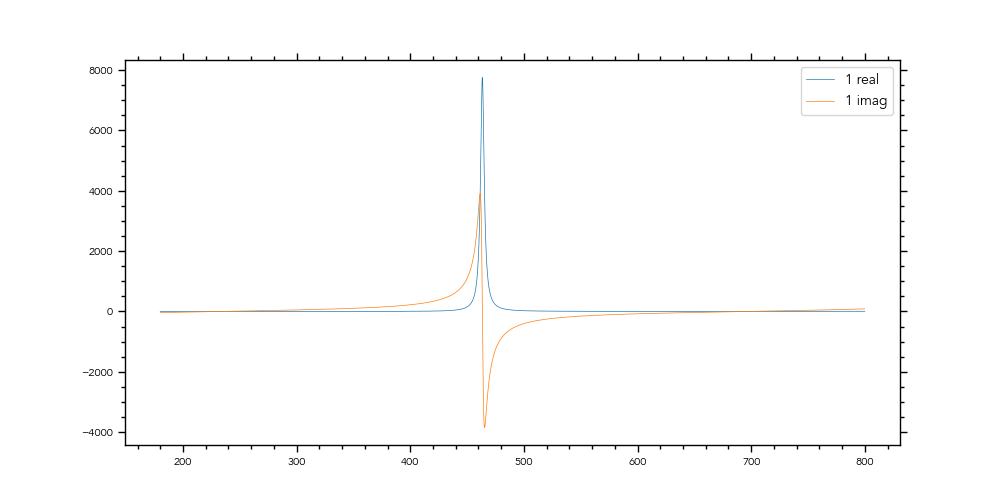

In [5]:
fig, ax =plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(10,5))




# ax.plot(f/1e9,np.real(Z_arm_and_coup))
# ax.plot(f/1e9,np.imag(Z_arm_and_coup))
ax.plot(f/1e9,np.real(Z_in1),label="1 real")
ax.plot(f/1e9,np.imag(Z_in1),label="1 imag")
# ax.plot(l_res2,np.real(Z_in2),label="2 real")
# ax.plot(l_res2,np.imag(Z_in2),label="2 imag")

ax.legend()


# Split point calculation

In [ ]:
nF = int(2e4)
f = np.linspace(200e9,460e9,nF)

nF = int(5e2)
f2 = np.linspace(345e9,355e9,nF)

f0_min = 220e9
f0_max = 440e9


R_spacings =[500,]
R_filter_widths = [500,]
n_R_spacings = len(R_spacings)
n_R_filter_widths = len(R_filter_widths)


## Variances
sigma_Ql = 0 # 0.2
sigma_f0 = 0 #0.085


Z0_res = 80
eps_eff_res = 40
Qi_res = 1120


Z0_thru = 80
eps_eff_thru = 40

TL_thru = TransmissionLine(Z0_thru,eps_eff_thru)

TL_res = TransmissionLine(Z0_res,eps_eff_res,Qi=Qi_res)

TransmissionLinesDict = {
    'through' : TL_thru,
    'resonator' : TL_res,
    'MKID' : TL_thru
}

Filters = (ManifoldFilter, DirectionalFilter)

In [18]:
split_point = dict()
for R_spacing in R_spacings:
    for R_filter_width in R_filter_widths:

        Ql = R_filter_width
        oversampling = R_spacing / R_filter_width

        n_filters = int(np.floor(1 + np.log10(f0_max / f0_min) / np.log10(1 + 1 / (Ql * oversampling))))

        f0 = np.zeros(n_filters)
        f0[0] = f0_min
        for i in np.arange(1,n_filters):
            f0[i] = f0[i-1] + f0[i-1] / (Ql * oversampling)
        f0 = np.flip(f0)

        lambda0 = c / f0 / np.sqrt(eps_eff_thru)

        quarter_lambda0 = lambda0/4

        l_fb = np.sum(quarter_lambda0)*2

        l_at_filter = 0
        for filter_i in range(n_filters):

            l_at_filter += quarter_lambda0[filter_i] * 2

            if l_at_filter > l_fb/2:
                split_point[(R_spacing,R_filter_width)] = filter_i
                break
        
        print(f"Split filter at filter {split_point[(R_spacing,R_filter_width)]} (of {n_filters} filters)")

Split filter at filter 202 (of 347 filters)


In [25]:
R_sweep_data = dict()

for Filter in Filters:
    Filterbank_data = dict()
    for R_spacing in R_spacings:
        for R_filter_width in R_filter_widths:
            

            FB = Filterbank(
                FilterClass=Filter,
                TransmissionLines=TransmissionLinesDict,
                f0_min=f0_min,
                f0_max=f0_max,
                Ql=R_filter_width,
                oversampling=R_spacing/R_filter_width,
                sigma_f0=sigma_f0 * (R_filter_width / 300),
                sigma_Ql=sigma_Ql,
                compensate=False
            )

            if Filter == DirectionalFilter:
                Filter_with_split : BaseFilter = FB.Filters[split_point[(R_spacing,R_filter_width)]]
                Filter_with_split.sep = Filter_with_split.TransmissionLine_through.wavelength(Filter_with_split.f0) * 50

            # Caculate S-Parameters and realized values (suppress output)
            FB.S(f);
            FB.realized_parameters();

            Filterbank_data[(R_spacing,R_filter_width)] = FB
    
    R_sweep_data[Filter] = Filterbank_data

            

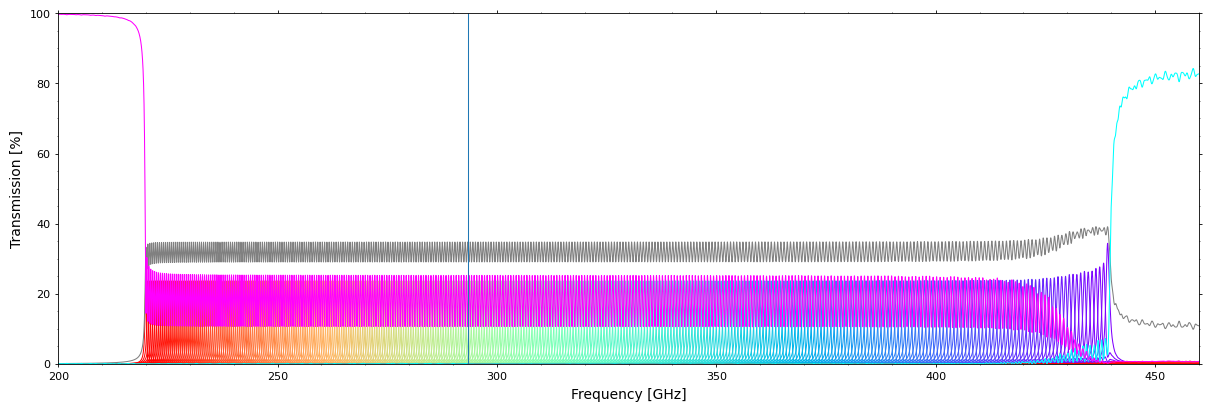

In [28]:
################################################
fig, ax =plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(12,4),layout='constrained')

FB : Filterbank = R_sweep_data[DirectionalFilter][(500,500)]
S31_all = FB.S31_absSq_list

#ax
cmap = cm.get_cmap('rainbow').copy()
norm = mpl.colors.Normalize(vmin=0, vmax=np.shape(S31_all)[0])

for i,S31_absSq in enumerate(S31_all):
    ax.plot(f/1e9,100*S31_absSq,color=cmap(norm(i)))

sum_filters = np.sum(S31_all,axis=0)
ax.plot(f/1e9,100*sum_filters,label='sum filters',color="0.5")

envelope = np.array(FB.S31_absSq_list).max(axis=0)
# ax.plot(f/1e9,100*envelope["DirectionalFilter"],label='envelope',color=(0.,0.,0.))

ax.plot(f/1e9,100*FB.S11_absSq,label='S11',color=(0.,1.,1.))
ax.plot(f/1e9,100*FB.S21_absSq,label='S21',color=(1.,0.,1.))
ax.vlines(Filterbank_data[(R_spacing,R_filter_width)].f0_realized[split_point[(R_spacing,R_filter_width)]]/1e9,100,0)

ax.set_ylim(0,100)
ax.set_xlim(np.min(f)/1e9,np.max(f)/1e9)
ax.set_xlabel('Frequency [GHz]');
ax.set_ylabel('Transmission [%]');  # Add a y-label to the axes.
# plt.title("Realized Q-factors")  # Add a title to the axes.
# ax.legend();  # Add a legend.

# savestr = fig_path + "Filterbank_DirectionalFilter.svg"
# plt.savefig(fname=savestr)
# fig.canvas.manager.set_window_title(savestr)



In [27]:
print(Filterbank_data[(R_spacing,R_filter_width)].Filters[split_point[(R_spacing,R_filter_width)]].sep)
print(Filterbank_data[(R_spacing,R_filter_width)].Filters[split_point[(R_spacing,R_filter_width)]+1].sep)


0.008079530603140718
4.0478448321734996e-05


In [ ]:
fig, axs = plt.subplots(nrows=n_R_spacings,ncols=n_R_filter_widths,sharex=True,sharey=True,figsize=(15,12),layout='constrained')

for row, ax_row in enumerate(axs):
    for col, ax in enumerate(ax_row):
        
        for Filter in Filters:
            filt_name = str(Filter.__name__)
            FB : Filterbank = R_sweep_data[Filter][(R_spacings[row],R_filter_widths[col])]
            ax.scatter(FB.f0_realized/1e9,FB.Ql_realized,label=f"{filt_name} ({np.mean(FB.Ql_realized):.1f})",color=Filtertype_color_dict[filt_name])
            ax.hlines(np.mean(FB.Ql_realized),FB.f0_min/1e9,FB.f0_max/1e9,color=Filtertype_color_dict[filt_name])
            ax.set_title(f"({R_spacings[row]}, {R_filter_widths[col]})")
            ax.legend(loc='upper left')


fig.supxlabel("freq. [GHz]");
fig.supylabel("Q-factor");
fig.suptitle("Ql realized (R spacing, R filter)");

In [ ]:
fig, axs = plt.subplots(nrows=n_R_spacings,ncols=n_R_filter_widths,sharex=True,sharey=True,figsize=(15,12),layout='constrained')

for row, ax_row in enumerate(axs):
    for col, ax in enumerate(ax_row):
        
        for Filter in Filters:
            filt_name = str(Filter.__name__)
            FB : Filterbank = R_sweep_data[Filter][(R_spacings[row],R_filter_widths[col])]
            ax.scatter(FB.f0_realized/1e9,FB.inband_filter_eff,label=f"{filt_name} ({np.mean(FB.inband_filter_eff):.3f})",color=Filtertype_color_dict[filt_name])
            ax.hlines(np.mean(FB.inband_filter_eff),FB.f0_min/1e9,FB.f0_max/1e9,color=Filtertype_color_dict[filt_name])
            ax.set_title(f"({R_spacings[row]}, {R_filter_widths[col]})")
            ax.legend(loc='upper left')


fig.supxlabel("freq. [GHz]");
fig.supylabel("Efficiency");
fig.suptitle("In-band filter efficiency (R spacing, R filter)");